In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV, inference
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [31]:
Q = 5
nconf = 31
ndata = 990
L = 64
T_cr = 0.852 # critical temp for 2d 5-Potts
t_start = 0.7
exclude_T = (0.8, 0.9)

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Potts", q=Q)
print(prm_list)
print(f"データ数:{nconf*ndata}")

[[0.7, '../dataset/2d_Potts/L64_q=5/L64T0_'], [0.71, '../dataset/2d_Potts/L64_q=5/L64T1_'], [0.72, '../dataset/2d_Potts/L64_q=5/L64T2_'], [0.73, '../dataset/2d_Potts/L64_q=5/L64T3_'], [0.74, '../dataset/2d_Potts/L64_q=5/L64T4_'], [0.75, '../dataset/2d_Potts/L64_q=5/L64T5_'], [0.76, '../dataset/2d_Potts/L64_q=5/L64T6_'], [0.77, '../dataset/2d_Potts/L64_q=5/L64T7_'], [0.78, '../dataset/2d_Potts/L64_q=5/L64T8_'], [0.79, '../dataset/2d_Potts/L64_q=5/L64T9_'], [0.8, '../dataset/2d_Potts/L64_q=5/L64T10_'], [0.81, '../dataset/2d_Potts/L64_q=5/L64T11_'], [0.82, '../dataset/2d_Potts/L64_q=5/L64T12_'], [0.83, '../dataset/2d_Potts/L64_q=5/L64T13_'], [0.84, '../dataset/2d_Potts/L64_q=5/L64T14_'], [0.85, '../dataset/2d_Potts/L64_q=5/L64T15_'], [0.86, '../dataset/2d_Potts/L64_q=5/L64T16_'], [0.87, '../dataset/2d_Potts/L64_q=5/L64T17_'], [0.88, '../dataset/2d_Potts/L64_q=5/L64T18_'], [0.89, '../dataset/2d_Potts/L64_q=5/L64T19_'], [0.9, '../dataset/2d_Potts/L64_q=5/L64T20_'], [0.91, '../dataset/2d_Pot

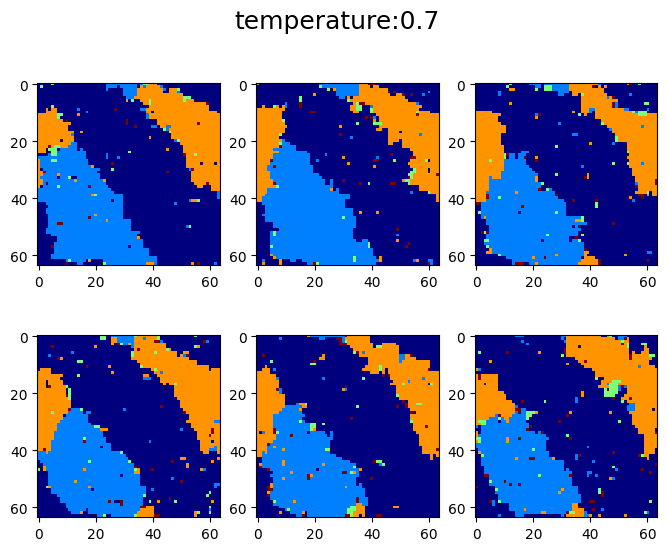

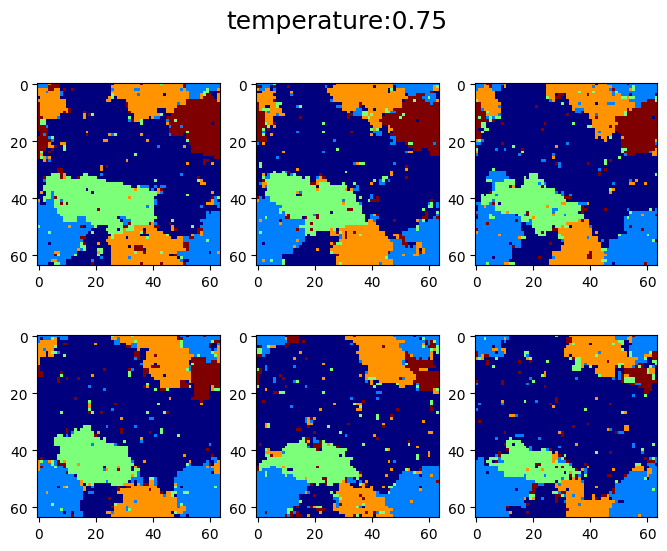

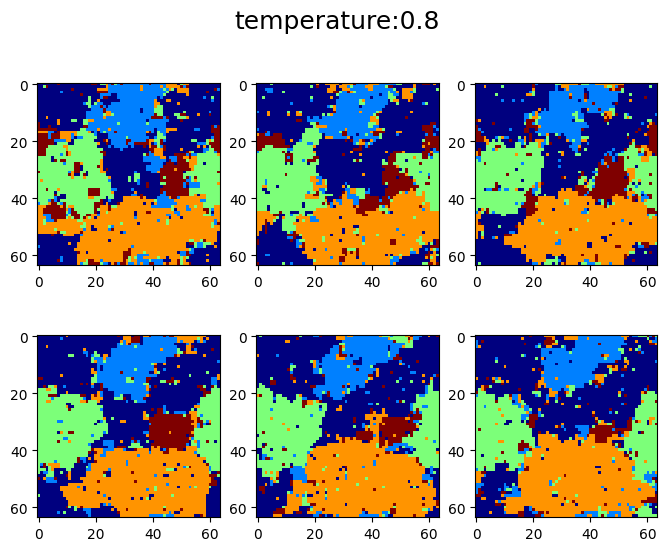

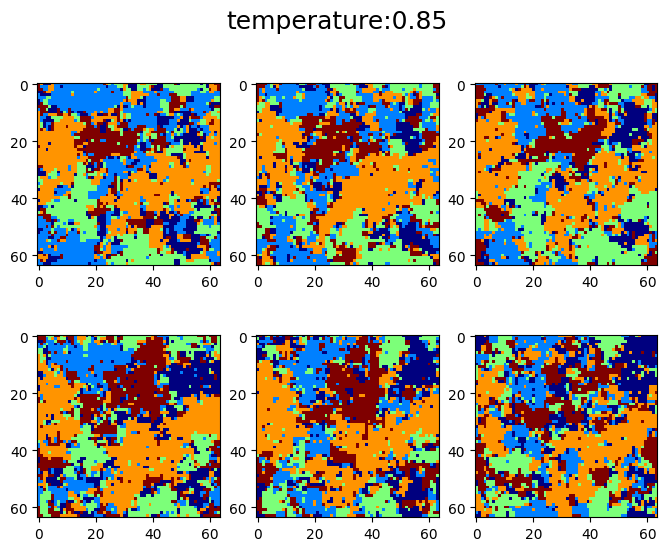

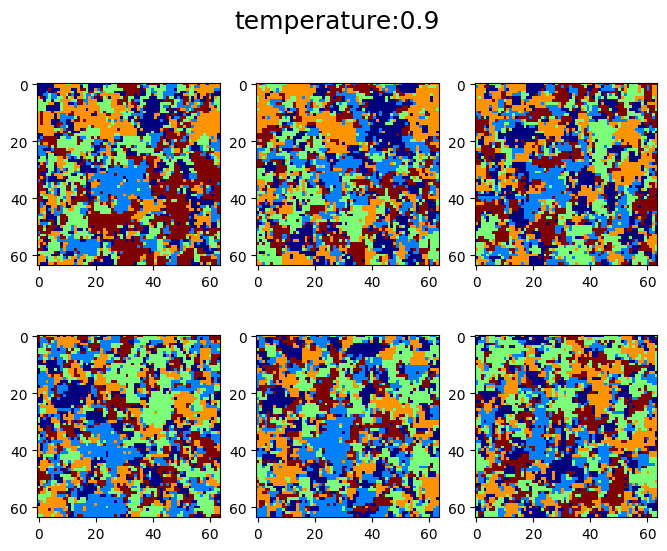

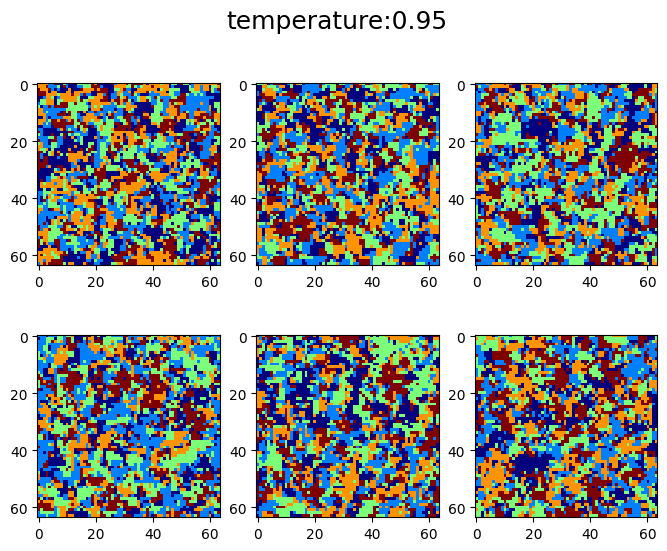

In [32]:
# 可視化
row = 2  # 行数
col = 3  # 列数

for num in range(0, 30, 5):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
    fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
    for iconf in range(6):
        _r = iconf//col
        _c = iconf % col
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')

In [33]:
dataset, _ = create_train_data_CV(prm_list, ndata, T_cr, exclude_T=exclude_T, total_label=2)
_, _, test_dataset = create_train_data_hold_out(prm_list, ndata, T_cr, exclude_T=exclude_T, total_label=2)

BATCH_SIZE = 128
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("dataset.shape = ", len(dataset))

dataset.shape =  19800


In [34]:
class CNNClassifier(nn.Module):
    def __init__(self, target_size):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        # self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(29*29*128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, target_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        # x = self.dropout1(x)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        # x = nn.MaxPool2d(2)(x)
        # x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

mps is available.
FOLD 1
--------------------------------
Epoch: 5, Validation loss: 2.3154050612709288e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       991
           1     1.0000    1.0000    1.0000       989

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



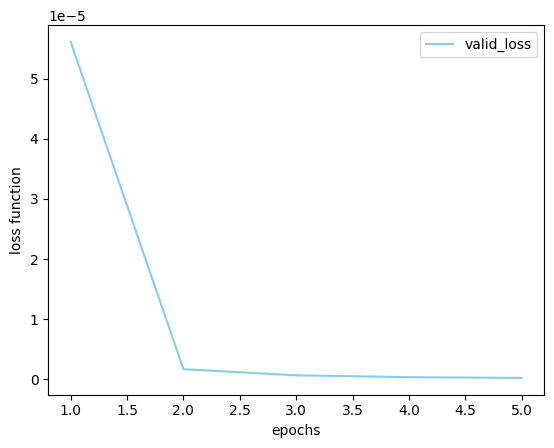

FOLD 2
--------------------------------
Epoch: 5, Validation loss: 2.629084887339926e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       982
           1     1.0000    1.0000    1.0000       998

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



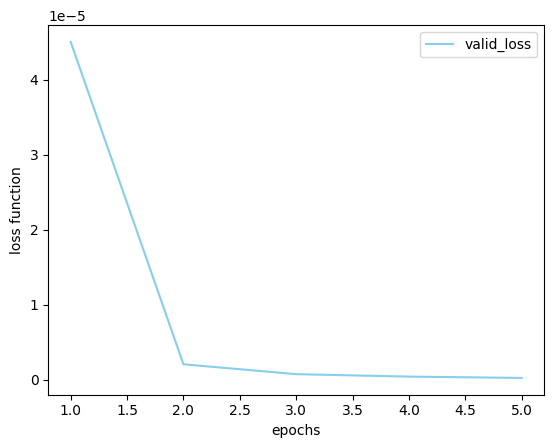

FOLD 3
--------------------------------
Epoch: 5, Validation loss: 1.6421037403830783e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1040
           1     1.0000    1.0000    1.0000       940

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



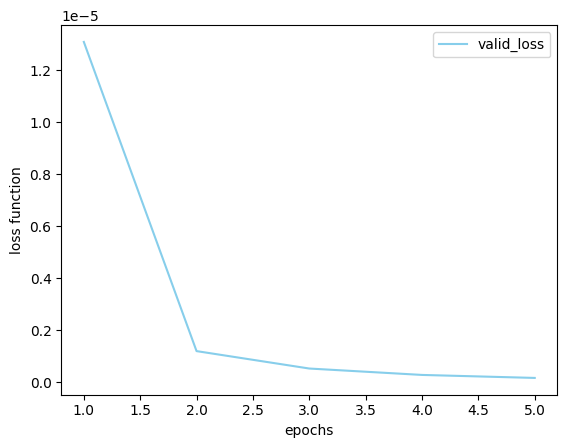

FOLD 4
--------------------------------
Epoch: 5, Validation loss: 2.4358407079654916e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       933
           1     1.0000    1.0000    1.0000      1047

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



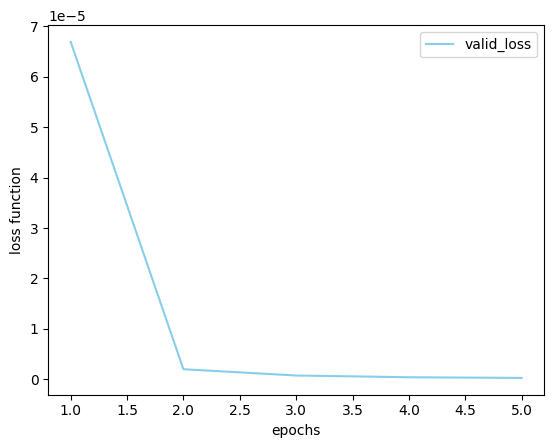

FOLD 5
--------------------------------
Epoch: 5, Validation loss: 2.9703563940887707e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       974
           1     1.0000    1.0000    1.0000      1006

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



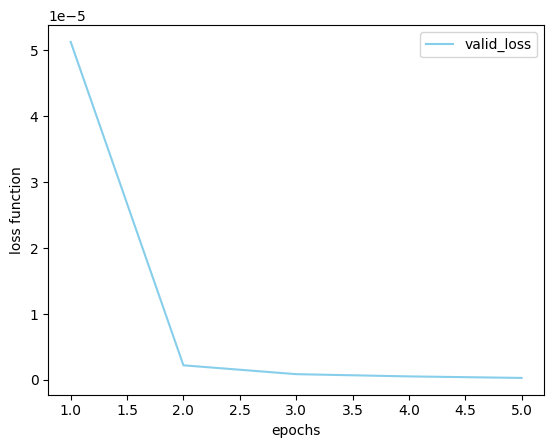

FOLD 6
--------------------------------
Epoch: 5, Validation loss: 2.3388069295300868e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       968
           1     1.0000    1.0000    1.0000      1012

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



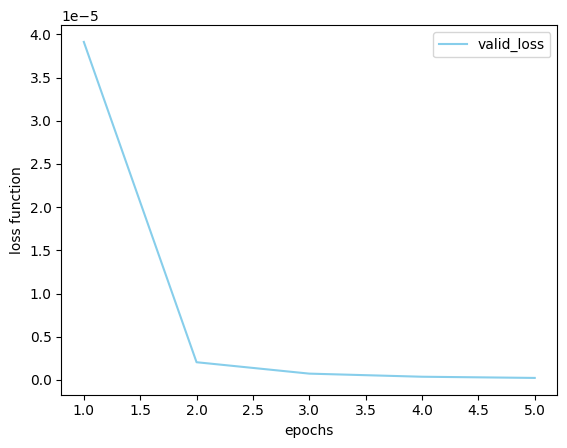

FOLD 7
--------------------------------
Epoch: 5, Validation loss: 2.6330679229247815e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1020
           1     1.0000    1.0000    1.0000       960

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



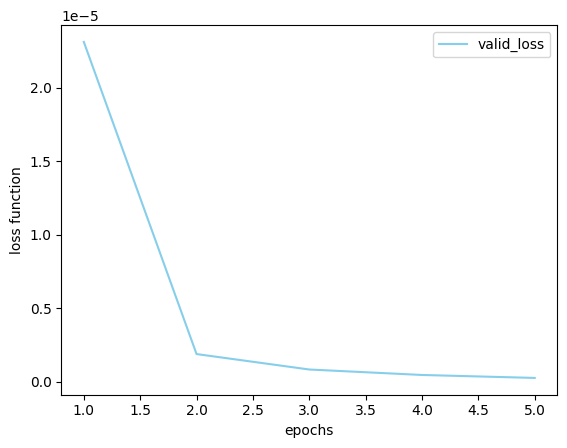

FOLD 8
--------------------------------
Epoch: 5, Validation loss: 2.167552200703402e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1035
           1     1.0000    1.0000    1.0000       945

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



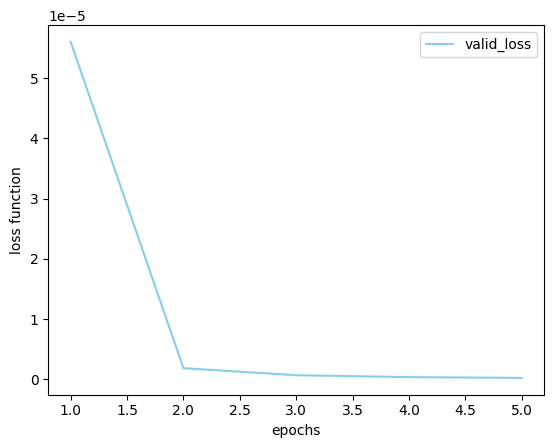

FOLD 9
--------------------------------
Epoch: 5, Validation loss: 2.2757092922646082e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       998
           1     1.0000    1.0000    1.0000       982

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



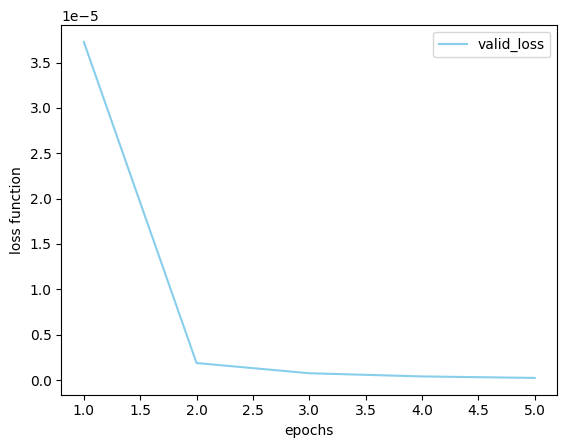

FOLD 10
--------------------------------
Epoch: 5, Validation loss: 4.1088985355342787e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       959
           1     1.0000    1.0000    1.0000      1021

    accuracy                         1.0000      1980
   macro avg     1.0000    1.0000    1.0000      1980
weighted avg     1.0000    1.0000    1.0000      1980



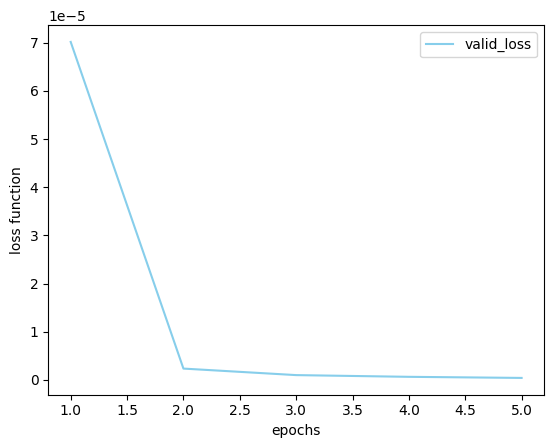

K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
Done.


In [35]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
LEARNING_RATE = 0.00001
target_size = 2
grad_clip = 0.1
norm_type = 2
epochs = 5
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

y1s_mean, y2s_mean = np.empty(nconf), np.empty(nconf)
for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

            answer_test, prediction_test, temps = [], [], []
            for data, temp, target in test_loader:
                data = data.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=False)
                prediction_test += list(pred.cpu().numpy())
                answer_test += list(target.cpu().numpy())
                temps += list(temp.cpu().numpy())
            xs, y1s, y2s = inference(len(test_dataset), temps, prediction_test, target_size)
            y1s_mean += y1s
            y2s_mean += y2s

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)
        y1s_mean /= k_folds
        y2s_mean /= k_folds

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs - 1:
            print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list,
             label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")
# torch.save(model, "2d_Clock_q=6_model_classifier.pth")

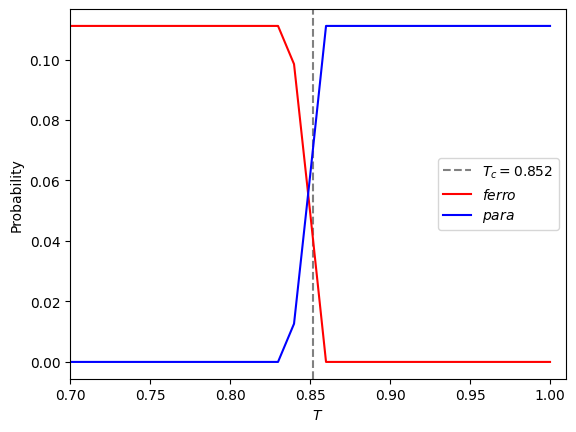

In [36]:
plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start,t_end)
plt.plot(xs, y1s_mean, label=r"$ferro$", color="red")
plt.plot(xs, y2s_mean, label=r"$para$", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()